In [40]:
using Plots, Random, Roots, FFTW, LaTeXStrings, DynamicalSystems, StatsBase

import PyPlot;
const plt = PyPlot;

# parameters
# physical cavity photon lifetime (and norm time)
tphys = 7.0 * 10^(-12);

# QW parameters
tg = 0.1 * 10^(-9);

# QD parameters
tρ = 0.1 * 10^(-9);
tn = 0.1 * 10^(-9);

delayphys = 0.7 * 10^(-9);

# normalized material parameters
# QW
etag = tphys / tg;

# QD
g = 1.15;
B = 924;
etaρ = tphys / tρ;
etan = tphys / tn;

α = 2;

# pump
JthrQW = 1;
JthrQD = ((1 + g) * (-B + g + B * g)) / (B * (-1 + g) * g);
nJthr = 1.5;
JQW = JthrQW * nJthr;
JQD = JthrQD * nJthr;

# optical feedback
τdelay = delayphys / tphys;
γ = 0.00;
ϕ = 0;
ϕs = [0, 0, 0];

# neighbor coupling
κ = 0.12;

# vectors of parameters
p0QW = [JQW, etag, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];
p0QD = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];

p0QD4 = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], ϕs[2], κ, τdelay];

t0 = 0;

# integration procedure parameters
dt = τdelay / 10000;
hist_len = floor(Int, τdelay / dt);
endtime = 40 * τdelay;
num_iter = floor(Int, endtime / dt);
n_lasers = 4
dimQW = n_lasers * 3; # problem dimension QW
dimQD = n_lasers * 4; # problem dimension QD
savnum = 500; # number of points per delay to save
modstep = floor(Int, hist_len / savnum);


Reind = zeros(Int,n_lasers)
Imind = zeros(Int,n_lasers)

# switch QW and QD
isQW = false;
if isQW
    p0 = copy(p0QW)
    dim = dimQW
    tauind = 10
    #Reind = [1,4,7]
    #Imind = [2,5,8]
    for i = 1:n_lasers
        Reind[i] = (i - 1)*3 + 1
        Imind[i] = (i - 1)*3 + 2
    end
else
    if n_lasers == 3
        p0 = copy(p0QD)
        tauind = 13
    else
        p0 = copy(p0QD4)
        tauind = 14
    end
    dim = dimQD
    #Reind = [1,5,9]
    #Imind = [2,6,10]
    
    for i = 1:n_lasers
        Reind[i] = (i - 1)*4 + 1
        Imind[i] = (i - 1)*4 + 2
    end
end

In [21]:
k12 = 1.0
k13 = 1.0
k14 = 1.0
k23 = 1.0
k24 = 1.0
k34 = 1.0

num_iter

400000

In [22]:
print(endtime)


3999.9999999999995

In [62]:
print(τdelay)

99.99999999999999

In [24]:
## function evaluating the derivatives for the iteration with the noise terms
# QW problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - etag
# p[3] - α
# p[4] - γ
# p[5] - ϕ
# p[6] - ϕs[1]
# p[7] - ϕs[2]
# p[8] - ϕs[2]
# p[9] - κ
# p[10] - τdelay

function QW(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * (1 - im * p[3]) * (u[3] - 1) * (u[1] + im * u[2]) +
        im *
        p[4] *
        exp(-im * p[5]) *
        (exp(-im * p[6]) * ET1 + exp(-im * p[7]) * ET2 + exp(-im * p[8]) * ET3) +
        im * p[9] * (E1 + E2)

    dn = p[2] * (p[1] - u[3] * (1 + u[1]^2 + u[2]^2))

    return [real(dF), imag(dF), dn]
end

function CoupledQW(u, uT, p, nt, t, t0)
    du1 = QW(
        u[1:3],
        u[4] + im * u[5],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du2 = QW(
        u[4:6],
        u[1] + im * u[2],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du3 = QW(
        u[7:9],
        u[1] + im * u[2],
        u[4] + im * u[5],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    return collect(Iterators.flatten([du1, du2, du3]))
end

CoupledQW (generic function with 1 method)

In [25]:
# QD problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - g
# p[3] - B
# p[4] - etaρ
# p[5] - etan
# p[6] - α
# p[7] - γ
# p[8] - ϕ
# p[9] - ϕs[1]
# p[10] - ϕs[2]
# p[11] - ϕs[2]
# p[12] - κ
# p[13] - τdelay

function FU(ρ, n, B)
    return B * n * (1 - ρ)
end

function QD(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) * (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (exp(-im * p[9]) * ET1 + exp(-im * p[10]) * ET2 + exp(-im * p[11]) * ET3) +
        im * p[12] * (E1 + E2)

    dρ = p[4] * (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end

du = [ [0.0,0.0,0.0,0.0] for i = 1:3  ]
#
function CoupledQD(u, uT, p, nt, t, t0)
    
    du1 = QD(
        u[1:4],
        u[5] + im * u[6],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du2 = QD(
        u[5:8],
        u[1] + im * u[2],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du3 = QD(
        u[9:12],
        u[1] + im * u[2],
        u[5] + im * u[6],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )
    
    return collect(Iterators.flatten([du1, du2, du3]))
    """

    uti1 = [5,1,1]
    uti2 = [9,9,5]


    for i = 1:3
        du[i] = QD(
            u[((i - 1)*4 + 1): ((i - 1)*4 + 4)],
            u[uti1[i]] + im * u[uti1[i] + 1],
            u[uti2[i]] + im * u[uti2[i] + 1],
            uT[1] + im * uT[2],
            uT[5] + im * uT[6],
            uT[9] + im * uT[10],
            p,
            nt,
        )
    end
    return collect(Iterators.flatten(du))"""
end

CoupledQD (generic function with 1 method)

In [137]:
function QD4(u, E1, E2, E3, ET1, ET2, ET3, ET4, p, nt)
    dF =
        0.5 *
        ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) *
        (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (
            exp(-im * p[9]) * ET1 +
            exp(-im * p[10]) * ET2 +
            exp(-im * p[11]) * ET3 +
            exp(-im * p[12]) * ET4
        ) +
        im * p[13] * (E1 + E2 + E3)
    print(im *
        p[7] *
        exp(-im * p[8]) *
        (
            exp(-im * p[9]) * ET1 +
            exp(-im * p[10]) * ET2 +
            exp(-im * p[11]) * ET3 +
            exp(-im * p[12]) * ET4
        ))
    dρ =
        p[4] *
        (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end

oneLaser = true
function CoupledQD4(u, uT, p, nt, t, t0)

    du = [[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0]]

    
    
    
    du[1] = QD4(
        u[1:4],
        (u[5] + im * u[6]) * k12,
        (u[9] + im * u[10]) * k13,
        (u[13] + im * u[14]) * k14,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    if oneLaser
        p[2] = g
    end
    
    du[2] = QD4(
        u[5:8],
        (u[1] + im * u[2]) * k12,
        (u[9] + im * u[10]) * k23,
        (u[13] + im * u[14]) * k24,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    du[3] = QD4(
        u[9:12],
        (u[1] + im * u[2]) * k13,
        (u[5] + im * u[6]) * k23,
        (u[13] + im * u[14]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    du[4] = QD4(
        u[13:16],
        (u[1] + im * u[2]) * k14,
        (u[5] + im * u[6]) * k24,
        (u[9] + im * u[10]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    return collect(Iterators.flatten(du))
end


CoupledQD4 (generic function with 1 method)

In [138]:
#arr = zeros(num_iter)
arr = 0
l = 1
## Semi-implicit Euler iteration procedure
# rhs should be the function of the form rhs(u,uT,p,nt,t,t0)
# SIEiters alterates qY, qYhead, qYtail and U
function SIEiters(rhs, num_iter, modstep, T, p, nt, qY1, qY2, qYtail, U, tind)
    # dimensions
    dim = size(qY1, 1)
    # length of the stored history
    hist_len = size(qY1, 2)
    # array with the current intermediate values of the function
    Y1 = zeros(dim)
    Y2 = zeros(dim)
    # them delayed
    YT1 = zeros(dim)
    YT2 = zeros(dim)

    # local variable for the tail
    lqYtail = qYtail[1]

    # initial values of the unknown
    Y1 = qY1[:, lqYtail]

    # local time variables
    t0 = T[1]
    tc = T[2]
    dt = T[3]

    # fixed tau
    ft = floor(Int, p[tind] / dt)

    # RK iterations
    for l = 1:num_iter
        
        
        # reading the time-delayed value of variables
        # the queue is stored in an array qY
        # the first index of qY is the number of the integration method subiteration
        # the second index is the point number inside the queue
        # the tail of the queue corresponds to the (t-dt) variables
        di = lqYtail - ft + 1
        if di < 1
            YT1 = qY1[:, hist_len+di]
            YT2 = qY2[:, hist_len+di]
        else
            YT1 = qY1[:, di]
            YT2 = qY2[:, di]
        end

        ntl = nt[l, :]
        
        p[2] = g
        if size(x,1) > l
            p[2] = g + g * (x[l])*(1)
        end
        # some semi-implicit calculations
        Y2 = Y1 + dt * rhs(Y1, YT1, p, ntl, tc, t0)

        # storing the time-delayed variables
        lqYtail = mod(lqYtail, hist_len) + 1
        qY1[:, lqYtail] = Y1
        qY2[:, lqYtail] = Y2
        
        p[2] = g
        if size(x,1) > l
            p[2] = g + g * (x[l])*(1)
        end

        # calculate the actual current-time variable
        Y1 = Y1 + dt * rhs(Y2, YT2, p, ntl, tc + dt, t0)

        # integration output
        if mod(l, modstep) == 0
            U[div(l, modstep), :] = Y1
        end

        tc = tc + dt
    end
    T[2] = tc
    
    #print("tc_end = ")
    #print(tc)
    #print("\n")
    qYtail[1] = lqYtail
end

SIEiters (generic function with 1 method)

In [128]:
## our initial history for SIE method subiterations
Random.seed!(1234)

qY1 = zeros(dim, hist_len);
qY2 = zeros(dim, hist_len);
for i = 1:hist_len
    qY1[:, i] = randn(dim) .^ 2
    qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
    qY2[:, i] = randn(dim) .^ 2
    qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
end

    

#### В качестве входного сигнала был загружен тестовый аудиофайл

In [ ]:
using FileIO: load, save, loadstreaming, savestreaming
import LibSndFile

x = load("1609518506_funk-2.wav");
#x = x[1][:,1]./ maximum(x[1][:,1]);

#### Позже, для простоты, он был заменен на ступенчатый сигнал

In [95]:
x = zeros(num_iter)
#for i = div(num_iter,3):(div(num_iter,3)*2)
for i = div(num_iter,2):num_iter
    x[i] = 1
end

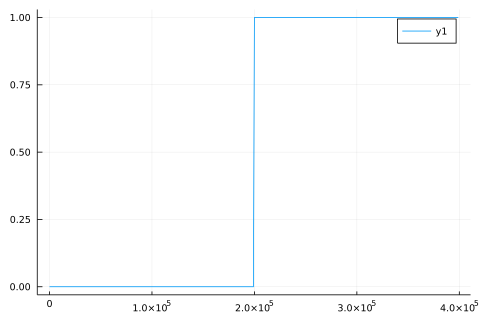

In [122]:
p_1 = plot(
    1:1000:size(x,1),
    x[1:1000:size(x,1)],
    dpi=80,
)
display(p_1)
savefig(p_1,string("ступ.png"))

In [115]:
Random.seed!(50)
k12 = rand(0:1000)/10000.0
println(k12)
k13 = rand(0:1000)/10000.0
println(k13)
k14 = rand(0:1000)/10000.0
println(k14)
k23 = rand(0:1000)/10000.0
println(k23)
k24 = rand(0:1000)/10000.0
println(k24)
k34 = rand(0:1000)/10000.0
println(k34)

0.0526
0.0044
0.0739
0.0956
0.0152
0.0515


In [129]:
## integration
U = zeros(div(num_iter, modstep), dim)

qYtail = [1];

Random.seed!(1234)

time_array = [t0, t0, dt]

# noise terms
nt = zeros(num_iter, 2);

#### Произведена симуляция взаимодействия лазеров с единичными коэффициентами

In [143]:
k12 = 0.0
k13 = 0.0
k14 = 0.0
k23 = 0.0
k24 = 0.0
k34 = 0.0

0.0

In [148]:

oneLaser = true
p0[7] = 0.0
if isQW
    @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
else
    if n_lasers == 3
        @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    end 
end

  2.143156 seconds (54.00 M allocations: 2.885 GiB, 16.37% gc time)


1

In [ ]:
pl_st_t = 0;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
p1 = plot(
    ts,
    forplot1,
    ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
    xlabel = "t",
    ylabel = "Intensity",
    label = "E₁",
    title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
    linecolor = :blue,
    dpi=80,
)
forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
p2 = plot(
    ts,
    forplot2,
    ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
    xlabel = "t",
    label = "E₂",
    linecolor = :green,
    dpi=80,
)
forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
p3 = plot(
    ts,
    forplot3,
    ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
    xlabel = "t",
    label = "E₃",
    linecolor = :red,
    dpi=80,
)
if n_lasers == 3 
    
    forplot4 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
    )
    p4 = plot(
        ts,
        forplot4,
        ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃",
        linecolor = :black,
        dpi=80,
    )
    pall = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)

    display(pall)
else
    forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
    p4 = plot(
        ts,
        forplot4,
        ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
        xlabel = "t",
        label = "E4",
        linecolor = :orange,
        dpi=80,
    )
    forplot5 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
    )
    p5 = plot(
        ts,
        forplot5,
        ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃+E4",
        linecolor = :black,
        dpi=80,
    )
    pall = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (800, 800),dpi=80)

    display(pall)


end

#### Далее произведен процесс симуляции для различных значений коэффициентов между лазерами
#### Коэффициенты подбирались случайным образом

In [150]:
p0[7] = 0.0
oneLaser = true
for rand_i=1:300
    if mod(rand_i,10) == 0
        print(rand_i)
    end
    Random.seed!(1234)

    
    qY1 = zeros(dim, hist_len);
    qY2 = zeros(dim, hist_len);
    for i = 1:hist_len
        qY1[:, i] = randn(dim) .^ 2
        qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
        qY2[:, i] = randn(dim) .^ 2
        qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
    end
    
    Random.seed!(rand_i)
    
    
    k12 = rand(0:1000)/10000.0
    k13 = rand(0:1000)/10000.0
    k14 = rand(0:1000)/10000.0
    k23 = rand(0:1000)/10000.0
    k24 = rand(0:1000)/10000.0
    k34 = rand(0:1000)/10000.0

    ## integration
    U = zeros(div(num_iter, modstep), dim)

    qYtail = [1];

    time_array = [t0, t0, dt]

    # noise terms
    nt = zeros(num_iter, 2)

    if isQW
        @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        if n_lasers == 3
            @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        else
            @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        end
    end

    pl_st_t = 0;
    pl_en_t = endtime;
    n = 3000; # number of timepoints for plot
    pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
    pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
    pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
    forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
    ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
    p1 = plot(
        ts,
        forplot1,
        ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
        xlabel = "t",
        ylabel = "Intensity",
        label = "E₁",
        title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
        linecolor = :blue,
        dpi=80,
    )
    if true
        forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
        p_2 = plot(
            ts,
            forplot2,
            ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
            xlabel = "t",
            label = "E₂",
            linecolor = :green,
            dpi=80,
        )
        forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
        p_3 = plot(
            ts,
            forplot3,
            ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
            xlabel = "t",
            label = "E₃",
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3 

            forplot4 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
            )
            p_4 = plot(
                ts,
                forplot4,
                ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃",
                linecolor = :black,
                dpi=80,
            )
            
            #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
        else
            forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
            p_4 = plot(
                ts,
                forplot4,
                ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
                xlabel = "t",
                label = "E4",
                linecolor = :orange,
                dpi=80,
            )
            forplot5 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
            )
            p_5 = plot(
                ts,
                forplot5,
                ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃+E4",
                linecolor = :black,
                dpi=80,
            )
            
            #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
        end

        pl_st_t = endtime - 800 * τdelay;
        pl_en_t = endtime;
        pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
        pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

        # optical spectrum
        optfreq =
            fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

        optspec1 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

        optspec2 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

        optspec3 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

        optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));
        optspec5 = optspec4
        optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
        if n_lasers == 3

            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
        else
            optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

            optspec5 =
                10 *
                log10.(abs2.(fftshift(fft(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));
            optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
            optspec5 = optspec5 .- optspec0dB;
        end
        # rf spectrum
        rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
        rfspec1 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
        rfspec2 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
        rfspec3 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
        rfspec4 =
            10 *
            log10.(abs2.(rfft(abs2.(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));

        rfspec5 = rfspec4

        rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
        if n_lasers == 3
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
        else
            rfspec4 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
            rfspec5 =
                10 *
                log10.(abs2.(rfft(abs2.(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));


            rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
            rfspec5 = rfspec5 .- optspec0dB;
        end
        p2 = plot(
            optfreq,
            optspec1,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec2,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec3,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        else

            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec5,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        end
        p3 = plot(
            rffreq,
            rfspec1,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec2,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec3,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        else
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec5,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        end
    end
    
    if n_lasers == 3
        p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (1100, 1100),dpi=100)
    else
        p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=100)
    end
    #display(pall)

    # save figure
    if isQW
        #savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
    else
        #savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("ОдинТест/QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,"_i=", rand_i,".png"))
    end
end

  2.103747 seconds (54.00 M allocations: 2.885 GiB, 16.46% gc time)
  2.055524 seconds (54.00 M allocations: 2.885 GiB, 15.76% gc time)
  2.116924 seconds (54.00 M allocations: 2.885 GiB, 16.28% gc time)
  2.191071 seconds (54.00 M allocations: 2.885 GiB, 16.18% gc time)
  2.219504 seconds (54.00 M allocations: 2.885 GiB, 29.97% gc time)
  1.781107 seconds (54.00 M allocations: 2.885 GiB, 16.44% gc time)
  1.823577 seconds (54.00 M allocations: 2.885 GiB, 16.77% gc time)
  2.009820 seconds (54.00 M allocations: 2.885 GiB, 16.92% gc time)
  2.065615 seconds (54.00 M allocations: 2.885 GiB, 16.18% gc time)
10  2.046614 seconds (54.00 M allocations: 2.885 GiB, 16.03% gc time)
  2.082394 seconds (54.00 M allocations: 2.885 GiB, 15.51% gc time)
  2.118317 seconds (54.00 M allocations: 2.885 GiB, 15.74% gc time)
  2.216462 seconds (54.00 M allocations: 2.885 GiB, 15.81% gc time)
  2.231943 seconds (54.00 M allocations: 2.885 GiB, 15.65% gc time)
  2.281804 seconds (54.00 M allocations: 2.885

  2.220992 seconds (54.00 M allocations: 2.885 GiB, 16.33% gc time)
  2.242211 seconds (54.00 M allocations: 2.885 GiB, 16.50% gc time)
  2.482600 seconds (54.00 M allocations: 2.885 GiB, 16.02% gc time)
  2.339831 seconds (54.00 M allocations: 2.885 GiB, 15.89% gc time)
  2.128852 seconds (54.00 M allocations: 2.885 GiB, 24.67% gc time)
  2.125711 seconds (54.00 M allocations: 2.885 GiB, 16.42% gc time)
  1.936793 seconds (54.00 M allocations: 2.885 GiB, 17.08% gc time)
  2.108002 seconds (54.00 M allocations: 2.885 GiB, 16.05% gc time)
130  2.116590 seconds (54.00 M allocations: 2.885 GiB, 15.88% gc time)
  2.088585 seconds (54.00 M allocations: 2.885 GiB, 16.21% gc time)
  2.133610 seconds (54.00 M allocations: 2.885 GiB, 15.51% gc time)
  2.247849 seconds (54.00 M allocations: 2.885 GiB, 15.50% gc time)
  2.157533 seconds (54.00 M allocations: 2.885 GiB, 15.95% gc time)
  2.363001 seconds (54.00 M allocations: 2.885 GiB, 15.63% gc time)
  2.297385 seconds (54.00 M allocations: 2.88

  2.053660 seconds (54.00 M allocations: 2.885 GiB, 15.88% gc time)
  2.056444 seconds (54.00 M allocations: 2.885 GiB, 15.80% gc time)
  2.117243 seconds (54.00 M allocations: 2.885 GiB, 15.85% gc time)
  2.124004 seconds (54.00 M allocations: 2.885 GiB, 15.77% gc time)
  2.157197 seconds (54.00 M allocations: 2.885 GiB, 15.67% gc time)
  2.015051 seconds (54.00 M allocations: 2.885 GiB, 23.30% gc time)
  1.749261 seconds (54.00 M allocations: 2.885 GiB, 15.97% gc time)
  1.805223 seconds (54.00 M allocations: 2.885 GiB, 16.20% gc time)
250  1.865823 seconds (54.00 M allocations: 2.885 GiB, 16.08% gc time)
  1.937317 seconds (54.00 M allocations: 2.885 GiB, 16.33% gc time)
  1.972336 seconds (54.00 M allocations: 2.885 GiB, 15.52% gc time)
  2.036287 seconds (54.00 M allocations: 2.885 GiB, 16.32% gc time)
  2.067043 seconds (54.00 M allocations: 2.885 GiB, 15.82% gc time)
  2.146788 seconds (54.00 M allocations: 2.885 GiB, 15.72% gc time)
  2.277636 seconds (54.00 M allocations: 2.88

### Результаты тестового прохода аудио сигнала доступны по ссылке:
#### https://drive.google.com/drive/folders/1-wfE3Z2vqJF6lj1Ku_jiQb7T8cZbP6xH?usp=sharing

#### Для простоты входной сигнал был заменен на ступенчаты сигнал у который первую половину времени равен "0", а вторую "1" 

### Результаты ступенчатого прохода доступны по ссылке:
#### https://drive.google.com/drive/folders/1vPdAaCJGqDOv3LeiQcVH4R3EAPy5IMr4?usp=sharing

#### Далее было предпринята попытка изучить изменение поведения в зависимости от увеличения значения гамма от 0 до 0.003 с шагом 0.001

In [17]:

gams = [0.001, 0.002, 0.003, 0.004, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
#for gamma_i = 0.03:0.01:0.05
for ii = 1:size(gams,1)
    print(ii)
end

1234567891011

In [16]:
size(gams)

(11,)

In [151]:

x = zeros(num_iter)
for i = div(num_iter,2):num_iter
    x[i] = 1
end
oneLaser = true
gams = [0.001, 0.002, 0.003, 0.004, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
#for gamma_i = 0.03:0.01:0.05
for ii = 1:size(gams,1)
    gamma_i = gams[ii]
    #gamma_i = 0,01
    for rand_i=1:300
        if mod(rand_i,10) == 0
            print(string("gamma = ",gamma_i, "   rand_i = ",rand_i))
        end
        
        Random.seed!(1234)
        qY1 = zeros(dim, hist_len);
        qY2 = zeros(dim, hist_len);
        for i = 1:hist_len
            qY1[:, i] = randn(dim) .^ 2
            qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
            qY2[:, i] = randn(dim) .^ 2
            qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
        end

        Random.seed!(rand_i)
        k12 = rand(0:1000)/10000.0
        k13 = rand(0:1000)/10000.0
        k14 = rand(0:1000)/10000.0
        k23 = rand(0:1000)/10000.0
        k24 = rand(0:1000)/10000.0
        k34 = rand(0:1000)/10000.0

        ## integration
        U = zeros(div(num_iter, modstep), dim)

        qYtail = [1];

        time_array = [t0, t0, dt]

        # noise terms
        nt = zeros(num_iter, 2)

        if isQW
            @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        else
            if n_lasers == 3
                @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
            else
                p0[7] = gamma_i
                @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
            end
        end

        pl_st_t = 0 #endtime - 10 * τdelay;
        pl_en_t = endtime;
        n = 3000; # number of timepoints for plot
        pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
        pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
        pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
        forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
        ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
        p1 = plot(
            ts,
            forplot1,
            ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
            xlabel = "t",
            ylabel = "Intensity",
            label = "E₁",
            title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34,"; γ=",gamma_i),
            linecolor = :blue,
            dpi=80,
        )
        if true
            forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
            p_2 = plot(
                ts,
                forplot2,
                ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
                xlabel = "t",
                label = "E₂",
                linecolor = :green,
                dpi=80,
            )
            forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
            p_3 = plot(
                ts,
                forplot3,
                ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
                xlabel = "t",
                label = "E₃",
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3 

                forplot4 =
                abs2.(
                    U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
                )
                p_4 = plot(
                    ts,
                    forplot4,
                    ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
                    xlabel = "t, ns",
                    label = "E₁+E₂+E₃",
                    linecolor = :black,
                    dpi=80,
                )

                #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
            else
                forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
                p_4 = plot(
                    ts,
                    forplot4,
                    ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
                    xlabel = "t",
                    label = "E4",
                    linecolor = :orange,
                    dpi=80,
                )
                forplot5 =
                abs2.(
                    U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
                )
                p_5 = plot(
                    ts,
                    forplot5,
                    ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
                    xlabel = "t, ns",
                    label = "E₁+E₂+E₃+E4",
                    linecolor = :black,
                    dpi=80,
                )

                #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
            end

            pl_st_t = endtime - 800 * τdelay;
            pl_en_t = endtime;
            pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
            pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

            # optical spectrum
            optfreq =
                fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

            optspec1 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

            optspec2 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

            optspec3 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

            optspec4 =
                10 *
                log10.(abs2.(fftshift(fft(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
                ))));
            optspec5 = optspec4
            optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
            if n_lasers == 3

                optspec1 = optspec1 .- optspec0dB;
                optspec2 = optspec2 .- optspec0dB;
                optspec3 = optspec3 .- optspec0dB;
                optspec4 = optspec4 .- optspec0dB;
            else
                optspec4 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

                optspec5 =
                    10 *
                    log10.(abs2.(fftshift(fft(
                        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                        U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                    ))));
                optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
                optspec1 = optspec1 .- optspec0dB;
                optspec2 = optspec2 .- optspec0dB;
                optspec3 = optspec3 .- optspec0dB;
                optspec4 = optspec4 .- optspec0dB;
                optspec5 = optspec5 .- optspec0dB;
            end
            # rf spectrum
            rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
            rfspec1 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
            rfspec2 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
            rfspec3 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
            rfspec4 =
                10 *
                log10.(abs2.(rfft(abs2.(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
                ))));

            rfspec5 = rfspec4

            rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
            if n_lasers == 3
                rfspec1 = rfspec1 .- optspec0dB;
                rfspec2 = rfspec2 .- optspec0dB;
                rfspec3 = rfspec3 .- optspec0dB;
                rfspec4 = rfspec4 .- optspec0dB;
            else
                rfspec4 =
                    10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
                rfspec5 =
                    10 *
                    log10.(abs2.(rfft(abs2.(
                        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                        U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                    ))));


                rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
                rfspec1 = rfspec1 .- optspec0dB;
                rfspec2 = rfspec2 .- optspec0dB;
                rfspec3 = rfspec3 .- optspec0dB;
                rfspec4 = rfspec4 .- optspec0dB;
                rfspec5 = rfspec5 .- optspec0dB;
            end
            p2 = plot(
                optfreq,
                optspec1,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :blue,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec2,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :green,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec3,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3
                plot!(
                    optfreq,
                    optspec4,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-10, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    ylims = (-100, 5),
                    dpi=80,
                )
            else

                plot!(
                    optfreq,
                    optspec4,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-20, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :orange,
                    dpi=80,
                )
                plot!(
                    optfreq,
                    optspec5,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-10, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    ylims = (-100, 5),
                    dpi=80,
                )
            end
            p3 = plot(
                rffreq,
                rfspec1,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :blue,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec2,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :green,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec3,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3
                plot!(
                    rffreq,
                    rfspec4,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylims = (-100, 5),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    dpi=80,
                )
            else
                plot!(
                    rffreq,
                    rfspec4,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :orange,
                    dpi=80,
                )
                plot!(
                    rffreq,
                    rfspec5,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylims = (-100, 5),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    dpi=80,
                )
            end
        end

        if n_lasers == 3
            p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (1100, 1100),dpi=100)
        else
            p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=100)
        end
        #display(pall)

        # save figure
        if isQW
            #savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
            savefig(p1,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        else
            #savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
            savefig(p1,string("одинGamma/","QD_nJ_", nJthr,"_kap_",κ,"_gam_",gamma_i,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,"_rand_i=", rand_i,".png"))
        end
    end
end

  2.264875 seconds (54.00 M allocations: 2.885 GiB, 15.44% gc time)
  2.271403 seconds (54.00 M allocations: 2.885 GiB, 29.46% gc time)
  1.765100 seconds (54.00 M allocations: 2.885 GiB, 16.56% gc time)
  1.896034 seconds (54.00 M allocations: 2.885 GiB, 16.37% gc time)
  2.026221 seconds (54.00 M allocations: 2.885 GiB, 15.96% gc time)
  2.035600 seconds (54.00 M allocations: 2.885 GiB, 16.10% gc time)
  2.166105 seconds (54.00 M allocations: 2.885 GiB, 16.24% gc time)
  2.153048 seconds (54.00 M allocations: 2.885 GiB, 15.87% gc time)
  2.223054 seconds (54.00 M allocations: 2.885 GiB, 15.83% gc time)
gamma = 0.001   rand_i = 10  2.170720 seconds (54.00 M allocations: 2.885 GiB, 16.25% gc time)
  2.301685 seconds (54.00 M allocations: 2.885 GiB, 16.01% gc time)
  2.409450 seconds (54.00 M allocations: 2.885 GiB, 15.57% gc time)
  2.380915 seconds (54.00 M allocations: 2.885 GiB, 30.08% gc time)
  1.845541 seconds (54.00 M allocations: 2.885 GiB, 16.67% gc time)
  1.842680 seconds (5

  2.283574 seconds (54.00 M allocations: 2.885 GiB, 15.65% gc time)
  2.340557 seconds (54.00 M allocations: 2.885 GiB, 29.82% gc time)
  1.860436 seconds (54.00 M allocations: 2.885 GiB, 16.99% gc time)
  1.919093 seconds (54.00 M allocations: 2.885 GiB, 16.37% gc time)
  2.001894 seconds (54.00 M allocations: 2.885 GiB, 16.85% gc time)
  2.074570 seconds (54.00 M allocations: 2.885 GiB, 17.49% gc time)
  2.141092 seconds (54.00 M allocations: 2.885 GiB, 16.92% gc time)
  2.249150 seconds (54.00 M allocations: 2.885 GiB, 17.61% gc time)
gamma = 0.001   rand_i = 240  2.232412 seconds (54.00 M allocations: 2.885 GiB, 17.24% gc time)
  2.216082 seconds (54.00 M allocations: 2.885 GiB, 16.17% gc time)
  2.379140 seconds (54.00 M allocations: 2.885 GiB, 16.25% gc time)
  2.306898 seconds (54.00 M allocations: 2.885 GiB, 16.01% gc time)
  2.141486 seconds (54.00 M allocations: 2.885 GiB, 24.44% gc time)
  1.832750 seconds (54.00 M allocations: 2.885 GiB, 16.38% gc time)
  1.940402 seconds (

  2.112630 seconds (54.00 M allocations: 2.885 GiB, 17.73% gc time)
gamma = 0.002   rand_i = 50  2.156958 seconds (54.00 M allocations: 2.885 GiB, 15.46% gc time)
  2.236632 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.262608 seconds (54.00 M allocations: 2.885 GiB, 15.12% gc time)
  2.178943 seconds (54.00 M allocations: 2.885 GiB, 15.36% gc time)
  2.120116 seconds (54.00 M allocations: 2.885 GiB, 24.19% gc time)
  1.947327 seconds (54.00 M allocations: 2.885 GiB, 16.83% gc time)
  2.023489 seconds (54.00 M allocations: 2.885 GiB, 17.03% gc time)
  2.112753 seconds (54.00 M allocations: 2.885 GiB, 18.36% gc time)
  2.292117 seconds (54.00 M allocations: 2.885 GiB, 17.35% gc time)
  2.306156 seconds (54.00 M allocations: 2.885 GiB, 16.40% gc time)
gamma = 0.002   rand_i = 60  2.412523 seconds (54.00 M allocations: 2.885 GiB, 15.30% gc time)
  2.296584 seconds (54.00 M allocations: 2.885 GiB, 15.69% gc time)
  2.359040 seconds (54.00 M allocations: 2.885 GiB, 16.10% gc 

  1.981088 seconds (54.00 M allocations: 2.885 GiB, 16.98% gc time)
  2.164075 seconds (54.00 M allocations: 2.885 GiB, 15.94% gc time)
  2.246682 seconds (54.00 M allocations: 2.885 GiB, 16.11% gc time)
  2.165891 seconds (54.00 M allocations: 2.885 GiB, 16.06% gc time)
  2.075505 seconds (54.00 M allocations: 2.885 GiB, 15.60% gc time)
gamma = 0.002   rand_i = 170  2.144147 seconds (54.00 M allocations: 2.885 GiB, 16.64% gc time)
  2.345255 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.300100 seconds (54.00 M allocations: 2.885 GiB, 15.63% gc time)
  2.628145 seconds (54.00 M allocations: 2.885 GiB, 14.93% gc time)
  2.421783 seconds (54.00 M allocations: 2.885 GiB, 14.80% gc time)
  2.473331 seconds (54.00 M allocations: 2.885 GiB, 30.12% gc time)
  1.870679 seconds (54.00 M allocations: 2.885 GiB, 16.83% gc time)
  2.055416 seconds (54.00 M allocations: 2.885 GiB, 15.76% gc time)
  2.107638 seconds (54.00 M allocations: 2.885 GiB, 15.29% gc time)
  2.042475 seconds (

  2.209903 seconds (54.00 M allocations: 2.885 GiB, 16.53% gc time)
  2.246092 seconds (54.00 M allocations: 2.885 GiB, 15.52% gc time)
  2.312418 seconds (54.00 M allocations: 2.885 GiB, 15.42% gc time)
  2.162075 seconds (54.00 M allocations: 2.885 GiB, 15.55% gc time)
  2.206227 seconds (54.00 M allocations: 2.885 GiB, 28.97% gc time)
  1.741278 seconds (54.00 M allocations: 2.885 GiB, 16.72% gc time)
  1.952995 seconds (54.00 M allocations: 2.885 GiB, 16.77% gc time)
  1.936274 seconds (54.00 M allocations: 2.885 GiB, 15.90% gc time)
  2.045126 seconds (54.00 M allocations: 2.885 GiB, 16.89% gc time)
gamma = 0.002   rand_i = 290  1.990612 seconds (54.00 M allocations: 2.885 GiB, 16.16% gc time)
  2.037841 seconds (54.00 M allocations: 2.885 GiB, 15.76% gc time)
  2.071379 seconds (54.00 M allocations: 2.885 GiB, 15.93% gc time)
  2.092369 seconds (54.00 M allocations: 2.885 GiB, 15.94% gc time)
  2.144439 seconds (54.00 M allocations: 2.885 GiB, 15.79% gc time)
  2.178749 seconds (

  1.803758 seconds (54.00 M allocations: 2.885 GiB, 16.42% gc time)
  1.954031 seconds (54.00 M allocations: 2.885 GiB, 16.11% gc time)
  1.927351 seconds (54.00 M allocations: 2.885 GiB, 16.25% gc time)
  1.959094 seconds (54.00 M allocations: 2.885 GiB, 15.84% gc time)
  2.018098 seconds (54.00 M allocations: 2.885 GiB, 15.96% gc time)
  2.044684 seconds (54.00 M allocations: 2.885 GiB, 15.94% gc time)
  2.079663 seconds (54.00 M allocations: 2.885 GiB, 16.11% gc time)
  2.132383 seconds (54.00 M allocations: 2.885 GiB, 15.91% gc time)
gamma = 0.003   rand_i = 220  2.156761 seconds (54.00 M allocations: 2.885 GiB, 16.35% gc time)
  2.193068 seconds (54.00 M allocations: 2.885 GiB, 16.15% gc time)
  2.207184 seconds (54.00 M allocations: 2.885 GiB, 29.56% gc time)
  1.744844 seconds (54.00 M allocations: 2.885 GiB, 16.45% gc time)
  1.809664 seconds (54.00 M allocations: 2.885 GiB, 16.51% gc time)
  1.879269 seconds (54.00 M allocations: 2.885 GiB, 16.55% gc time)
  1.977338 seconds (

  2.160442 seconds (54.00 M allocations: 2.885 GiB, 16.23% gc time)
  2.199760 seconds (54.00 M allocations: 2.885 GiB, 16.09% gc time)
gamma = 0.004   rand_i = 30  2.202576 seconds (54.00 M allocations: 2.885 GiB, 29.33% gc time)
  1.768278 seconds (54.00 M allocations: 2.885 GiB, 16.37% gc time)
  1.833411 seconds (54.00 M allocations: 2.885 GiB, 16.47% gc time)
  1.873981 seconds (54.00 M allocations: 2.885 GiB, 16.21% gc time)
  1.937395 seconds (54.00 M allocations: 2.885 GiB, 15.94% gc time)
  1.984766 seconds (54.00 M allocations: 2.885 GiB, 16.34% gc time)
  2.040573 seconds (54.00 M allocations: 2.885 GiB, 15.79% gc time)
  2.065314 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.115995 seconds (54.00 M allocations: 2.885 GiB, 15.58% gc time)
  2.123909 seconds (54.00 M allocations: 2.885 GiB, 15.75% gc time)
gamma = 0.004   rand_i = 40  2.151857 seconds (54.00 M allocations: 2.885 GiB, 15.63% gc time)
  2.167890 seconds (54.00 M allocations: 2.885 GiB, 15.46% gc 

  2.040620 seconds (54.00 M allocations: 2.885 GiB, 15.90% gc time)
  2.085094 seconds (54.00 M allocations: 2.885 GiB, 15.94% gc time)
  2.120859 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.126737 seconds (54.00 M allocations: 2.885 GiB, 15.77% gc time)
  2.159102 seconds (54.00 M allocations: 2.885 GiB, 15.69% gc time)
  2.171587 seconds (54.00 M allocations: 2.885 GiB, 15.45% gc time)
gamma = 0.004   rand_i = 150  2.196422 seconds (54.00 M allocations: 2.885 GiB, 29.85% gc time)
  1.747405 seconds (54.00 M allocations: 2.885 GiB, 16.74% gc time)
  1.824586 seconds (54.00 M allocations: 2.885 GiB, 16.70% gc time)
  1.881368 seconds (54.00 M allocations: 2.885 GiB, 16.43% gc time)
  1.942408 seconds (54.00 M allocations: 2.885 GiB, 16.61% gc time)
  1.994691 seconds (54.00 M allocations: 2.885 GiB, 16.30% gc time)
  2.061990 seconds (54.00 M allocations: 2.885 GiB, 16.15% gc time)
  2.128644 seconds (54.00 M allocations: 2.885 GiB, 16.23% gc time)
  2.152313 seconds (

  2.134287 seconds (54.00 M allocations: 2.885 GiB, 15.82% gc time)
  2.160118 seconds (54.00 M allocations: 2.885 GiB, 16.31% gc time)
  2.187958 seconds (54.00 M allocations: 2.885 GiB, 15.65% gc time)
  2.215819 seconds (54.00 M allocations: 2.885 GiB, 15.34% gc time)
  2.359897 seconds (54.00 M allocations: 2.885 GiB, 30.10% gc time)
  1.850246 seconds (54.00 M allocations: 2.885 GiB, 16.46% gc time)
gamma = 0.007   rand_i = 80  1.908850 seconds (54.00 M allocations: 2.885 GiB, 16.43% gc time)
  1.986135 seconds (54.00 M allocations: 2.885 GiB, 15.76% gc time)
  1.940690 seconds (54.00 M allocations: 2.885 GiB, 15.95% gc time)
  2.065502 seconds (54.00 M allocations: 2.885 GiB, 16.36% gc time)
  2.078206 seconds (54.00 M allocations: 2.885 GiB, 16.19% gc time)
  2.186690 seconds (54.00 M allocations: 2.885 GiB, 15.74% gc time)
  2.212398 seconds (54.00 M allocations: 2.885 GiB, 16.06% gc time)
  2.202597 seconds (54.00 M allocations: 2.885 GiB, 15.66% gc time)
  2.183470 seconds (5

gamma = 0.007   rand_i = 190  1.938721 seconds (54.00 M allocations: 2.885 GiB, 15.99% gc time)
  1.972408 seconds (54.00 M allocations: 2.885 GiB, 15.68% gc time)
  2.029922 seconds (54.00 M allocations: 2.885 GiB, 15.80% gc time)
  2.069646 seconds (54.00 M allocations: 2.885 GiB, 15.81% gc time)
  2.120819 seconds (54.00 M allocations: 2.885 GiB, 15.51% gc time)
  2.119566 seconds (54.00 M allocations: 2.885 GiB, 15.72% gc time)
  2.159416 seconds (54.00 M allocations: 2.885 GiB, 15.54% gc time)
  2.195559 seconds (54.00 M allocations: 2.885 GiB, 15.71% gc time)
  2.216158 seconds (54.00 M allocations: 2.885 GiB, 29.35% gc time)
  1.755623 seconds (54.00 M allocations: 2.885 GiB, 16.33% gc time)
gamma = 0.007   rand_i = 200  1.819852 seconds (54.00 M allocations: 2.885 GiB, 15.97% gc time)
  1.902606 seconds (54.00 M allocations: 2.885 GiB, 16.29% gc time)
  1.957188 seconds (54.00 M allocations: 2.885 GiB, 16.02% gc time)
  1.980161 seconds (54.00 M allocations: 2.885 GiB, 15.74% g

  2.177073 seconds (54.00 M allocations: 2.885 GiB, 29.32% gc time)
  1.735362 seconds (54.00 M allocations: 2.885 GiB, 16.20% gc time)
  1.832927 seconds (54.00 M allocations: 2.885 GiB, 16.42% gc time)
  1.893339 seconds (54.00 M allocations: 2.885 GiB, 16.53% gc time)
gamma = 0.01   rand_i = 10  1.970601 seconds (54.00 M allocations: 2.885 GiB, 16.04% gc time)
  2.009124 seconds (54.00 M allocations: 2.885 GiB, 16.46% gc time)
  2.056558 seconds (54.00 M allocations: 2.885 GiB, 16.53% gc time)
  2.078802 seconds (54.00 M allocations: 2.885 GiB, 15.87% gc time)
  2.176963 seconds (54.00 M allocations: 2.885 GiB, 16.25% gc time)
  2.138820 seconds (54.00 M allocations: 2.885 GiB, 15.63% gc time)
  2.146243 seconds (54.00 M allocations: 2.885 GiB, 15.38% gc time)
  2.169845 seconds (54.00 M allocations: 2.885 GiB, 15.26% gc time)
  2.178790 seconds (54.00 M allocations: 2.885 GiB, 29.36% gc time)
  1.775826 seconds (54.00 M allocations: 2.885 GiB, 16.74% gc time)
gamma = 0.01   rand_i 

  2.132859 seconds (54.00 M allocations: 2.885 GiB, 16.01% gc time)
  2.179466 seconds (54.00 M allocations: 2.885 GiB, 15.89% gc time)
  2.174613 seconds (54.00 M allocations: 2.885 GiB, 15.89% gc time)
  2.199182 seconds (54.00 M allocations: 2.885 GiB, 15.72% gc time)
  2.076461 seconds (54.00 M allocations: 2.885 GiB, 23.37% gc time)
  1.797635 seconds (54.00 M allocations: 2.885 GiB, 16.35% gc time)
  1.886540 seconds (54.00 M allocations: 2.885 GiB, 16.12% gc time)
  1.944037 seconds (54.00 M allocations: 2.885 GiB, 16.65% gc time)
gamma = 0.01   rand_i = 130  2.007927 seconds (54.00 M allocations: 2.885 GiB, 15.80% gc time)
  2.086055 seconds (54.00 M allocations: 2.885 GiB, 16.32% gc time)
  2.178027 seconds (54.00 M allocations: 2.885 GiB, 16.29% gc time)
  2.098860 seconds (54.00 M allocations: 2.885 GiB, 15.92% gc time)
  2.126621 seconds (54.00 M allocations: 2.885 GiB, 16.10% gc time)
  2.176314 seconds (54.00 M allocations: 2.885 GiB, 15.86% gc time)
  2.194732 seconds (5

  2.294320 seconds (54.00 M allocations: 2.885 GiB, 15.40% gc time)
  2.207729 seconds (54.00 M allocations: 2.885 GiB, 28.99% gc time)
  1.789651 seconds (54.00 M allocations: 2.885 GiB, 16.73% gc time)
  1.875869 seconds (54.00 M allocations: 2.885 GiB, 16.26% gc time)
  1.942494 seconds (54.00 M allocations: 2.885 GiB, 16.43% gc time)
  1.997707 seconds (54.00 M allocations: 2.885 GiB, 16.40% gc time)
  2.053716 seconds (54.00 M allocations: 2.885 GiB, 16.51% gc time)
gamma = 0.02   rand_i = 60  2.068472 seconds (54.00 M allocations: 2.885 GiB, 16.19% gc time)
  2.126866 seconds (54.00 M allocations: 2.885 GiB, 15.67% gc time)
  2.128596 seconds (54.00 M allocations: 2.885 GiB, 16.04% gc time)
  2.189023 seconds (54.00 M allocations: 2.885 GiB, 15.23% gc time)
  2.207524 seconds (54.00 M allocations: 2.885 GiB, 15.95% gc time)
  2.223242 seconds (54.00 M allocations: 2.885 GiB, 15.74% gc time)
  2.240559 seconds (54.00 M allocations: 2.885 GiB, 28.74% gc time)
  1.798384 seconds (54

gamma = 0.02   rand_i = 170  2.136258 seconds (54.00 M allocations: 2.885 GiB, 16.19% gc time)
  2.188789 seconds (54.00 M allocations: 2.885 GiB, 15.83% gc time)
  2.177219 seconds (54.00 M allocations: 2.885 GiB, 15.91% gc time)
  2.206393 seconds (54.00 M allocations: 2.885 GiB, 15.71% gc time)
  2.230072 seconds (54.00 M allocations: 2.885 GiB, 29.45% gc time)
  1.761864 seconds (54.00 M allocations: 2.885 GiB, 16.29% gc time)
  1.852513 seconds (54.00 M allocations: 2.885 GiB, 16.74% gc time)
  1.941758 seconds (54.00 M allocations: 2.885 GiB, 16.44% gc time)
  2.065272 seconds (54.00 M allocations: 2.885 GiB, 16.50% gc time)
  2.099302 seconds (54.00 M allocations: 2.885 GiB, 16.62% gc time)
gamma = 0.02   rand_i = 180  2.159077 seconds (54.00 M allocations: 2.885 GiB, 16.40% gc time)
  2.095128 seconds (54.00 M allocations: 2.885 GiB, 16.10% gc time)
  2.195537 seconds (54.00 M allocations: 2.885 GiB, 15.92% gc time)
  2.140958 seconds (54.00 M allocations: 2.885 GiB, 15.71% gc 

  2.010734 seconds (54.00 M allocations: 2.885 GiB, 15.85% gc time)
  2.081366 seconds (54.00 M allocations: 2.885 GiB, 16.55% gc time)
  2.051942 seconds (54.00 M allocations: 2.885 GiB, 16.03% gc time)
  2.119509 seconds (54.00 M allocations: 2.885 GiB, 16.08% gc time)
gamma = 0.02   rand_i = 290  2.171105 seconds (54.00 M allocations: 2.885 GiB, 15.26% gc time)
  2.140632 seconds (54.00 M allocations: 2.885 GiB, 16.05% gc time)
  2.224510 seconds (54.00 M allocations: 2.885 GiB, 15.56% gc time)
  2.234580 seconds (54.00 M allocations: 2.885 GiB, 16.38% gc time)
  2.247479 seconds (54.00 M allocations: 2.885 GiB, 29.12% gc time)
  1.782580 seconds (54.00 M allocations: 2.885 GiB, 16.64% gc time)
  1.857664 seconds (54.00 M allocations: 2.885 GiB, 15.83% gc time)
  1.910572 seconds (54.00 M allocations: 2.885 GiB, 16.00% gc time)
  1.975546 seconds (54.00 M allocations: 2.885 GiB, 16.38% gc time)
  2.058089 seconds (54.00 M allocations: 2.885 GiB, 15.58% gc time)
gamma = 0.02   rand_i

  2.254933 seconds (54.00 M allocations: 2.885 GiB, 29.89% gc time)
  1.821472 seconds (54.00 M allocations: 2.885 GiB, 16.55% gc time)
  1.875284 seconds (54.00 M allocations: 2.885 GiB, 16.36% gc time)
  1.962866 seconds (54.00 M allocations: 2.885 GiB, 16.24% gc time)
  2.004052 seconds (54.00 M allocations: 2.885 GiB, 15.91% gc time)
  1.985459 seconds (54.00 M allocations: 2.885 GiB, 15.81% gc time)
  2.307707 seconds (54.00 M allocations: 2.885 GiB, 15.58% gc time)
  2.309726 seconds (54.00 M allocations: 2.885 GiB, 16.03% gc time)
gamma = 0.03   rand_i = 110  2.403675 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.509970 seconds (54.00 M allocations: 2.885 GiB, 15.74% gc time)
  3.067946 seconds (54.00 M allocations: 2.885 GiB, 14.54% gc time)
  3.078187 seconds (54.00 M allocations: 2.885 GiB, 14.65% gc time)
  3.258658 seconds (54.00 M allocations: 2.885 GiB, 27.66% gc time)
  2.174173 seconds (54.00 M allocations: 2.885 GiB, 15.89% gc time)
  2.615760 seconds (5

  1.932526 seconds (54.00 M allocations: 2.885 GiB, 16.07% gc time)
  1.977295 seconds (54.00 M allocations: 2.885 GiB, 16.45% gc time)
  2.042115 seconds (54.00 M allocations: 2.885 GiB, 16.03% gc time)
  2.106583 seconds (54.00 M allocations: 2.885 GiB, 15.92% gc time)
  2.084659 seconds (54.00 M allocations: 2.885 GiB, 15.93% gc time)
  2.146078 seconds (54.00 M allocations: 2.885 GiB, 16.35% gc time)
  2.199521 seconds (54.00 M allocations: 2.885 GiB, 15.38% gc time)
gamma = 0.04   rand_i = 40  2.221132 seconds (54.00 M allocations: 2.885 GiB, 16.10% gc time)
  2.318259 seconds (54.00 M allocations: 2.885 GiB, 16.08% gc time)
  2.263399 seconds (54.00 M allocations: 2.885 GiB, 29.65% gc time)
  1.816614 seconds (54.00 M allocations: 2.885 GiB, 16.42% gc time)
  1.965418 seconds (54.00 M allocations: 2.885 GiB, 16.14% gc time)
  2.007153 seconds (54.00 M allocations: 2.885 GiB, 17.21% gc time)
  2.064787 seconds (54.00 M allocations: 2.885 GiB, 16.37% gc time)
  2.129836 seconds (54

gamma = 0.04   rand_i = 150  2.056772 seconds (54.00 M allocations: 2.885 GiB, 23.43% gc time)
  1.788670 seconds (54.00 M allocations: 2.885 GiB, 16.53% gc time)
  1.866149 seconds (54.00 M allocations: 2.885 GiB, 16.35% gc time)
  1.984059 seconds (54.00 M allocations: 2.885 GiB, 16.53% gc time)
  2.055484 seconds (54.00 M allocations: 2.885 GiB, 17.03% gc time)
  2.125405 seconds (54.00 M allocations: 2.885 GiB, 16.02% gc time)
  2.061566 seconds (54.00 M allocations: 2.885 GiB, 15.99% gc time)
  2.090040 seconds (54.00 M allocations: 2.885 GiB, 15.29% gc time)
  2.140350 seconds (54.00 M allocations: 2.885 GiB, 16.01% gc time)
  2.222595 seconds (54.00 M allocations: 2.885 GiB, 15.72% gc time)
gamma = 0.04   rand_i = 160  2.240512 seconds (54.00 M allocations: 2.885 GiB, 16.19% gc time)
  2.246995 seconds (54.00 M allocations: 2.885 GiB, 16.44% gc time)
  2.267445 seconds (54.00 M allocations: 2.885 GiB, 29.79% gc time)
  1.883949 seconds (54.00 M allocations: 2.885 GiB, 17.27% gc 

  2.176433 seconds (54.00 M allocations: 2.885 GiB, 16.00% gc time)
  2.192851 seconds (54.00 M allocations: 2.885 GiB, 15.82% gc time)
  2.205231 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.237335 seconds (54.00 M allocations: 2.885 GiB, 16.24% gc time)
gamma = 0.04   rand_i = 270  2.244839 seconds (54.00 M allocations: 2.885 GiB, 29.18% gc time)
  1.809269 seconds (54.00 M allocations: 2.885 GiB, 16.84% gc time)
  1.873241 seconds (54.00 M allocations: 2.885 GiB, 16.39% gc time)
  1.927258 seconds (54.00 M allocations: 2.885 GiB, 16.23% gc time)
  1.994674 seconds (54.00 M allocations: 2.885 GiB, 16.63% gc time)
  2.067202 seconds (54.00 M allocations: 2.885 GiB, 16.56% gc time)
  2.061347 seconds (54.00 M allocations: 2.885 GiB, 16.16% gc time)
  2.113405 seconds (54.00 M allocations: 2.885 GiB, 16.23% gc time)
  2.186224 seconds (54.00 M allocations: 2.885 GiB, 15.91% gc time)
  2.211503 seconds (54.00 M allocations: 2.885 GiB, 15.97% gc time)
gamma = 0.04   rand_i

  1.970891 seconds (54.00 M allocations: 2.885 GiB, 16.04% gc time)
  2.010044 seconds (54.00 M allocations: 2.885 GiB, 16.14% gc time)
  2.055273 seconds (54.00 M allocations: 2.885 GiB, 16.19% gc time)
  2.092901 seconds (54.00 M allocations: 2.885 GiB, 15.59% gc time)
  2.129813 seconds (54.00 M allocations: 2.885 GiB, 16.09% gc time)
  2.153249 seconds (54.00 M allocations: 2.885 GiB, 15.43% gc time)
  2.196452 seconds (54.00 M allocations: 2.885 GiB, 15.90% gc time)
  2.242687 seconds (54.00 M allocations: 2.885 GiB, 16.27% gc time)
gamma = 0.05   rand_i = 90  2.060909 seconds (54.00 M allocations: 2.885 GiB, 23.67% gc time)
  1.798167 seconds (54.00 M allocations: 2.885 GiB, 16.33% gc time)
  1.897251 seconds (54.00 M allocations: 2.885 GiB, 16.17% gc time)
  1.925449 seconds (54.00 M allocations: 2.885 GiB, 16.36% gc time)
  2.083525 seconds (54.00 M allocations: 2.885 GiB, 16.27% gc time)
  2.041913 seconds (54.00 M allocations: 2.885 GiB, 16.68% gc time)
  2.082457 seconds (54

  2.097269 seconds (54.00 M allocations: 2.885 GiB, 15.66% gc time)
  2.132051 seconds (54.00 M allocations: 2.885 GiB, 15.81% gc time)
  2.133365 seconds (54.00 M allocations: 2.885 GiB, 14.90% gc time)
  2.183702 seconds (54.00 M allocations: 2.885 GiB, 15.37% gc time)
  2.238817 seconds (54.00 M allocations: 2.885 GiB, 15.18% gc time)
  2.049522 seconds (54.00 M allocations: 2.885 GiB, 23.44% gc time)
  1.822961 seconds (54.00 M allocations: 2.885 GiB, 16.46% gc time)
gamma = 0.1   rand_i = 20  1.840502 seconds (54.00 M allocations: 2.885 GiB, 16.22% gc time)
  1.894774 seconds (54.00 M allocations: 2.885 GiB, 15.96% gc time)
  1.948278 seconds (54.00 M allocations: 2.885 GiB, 15.76% gc time)
  2.003284 seconds (54.00 M allocations: 2.885 GiB, 15.51% gc time)
  2.047084 seconds (54.00 M allocations: 2.885 GiB, 15.67% gc time)
  2.054401 seconds (54.00 M allocations: 2.885 GiB, 15.13% gc time)
  2.119921 seconds (54.00 M allocations: 2.885 GiB, 15.63% gc time)
  2.115868 seconds (54.

gamma = 0.1   rand_i = 130  1.938210 seconds (54.00 M allocations: 2.885 GiB, 15.64% gc time)
  2.017723 seconds (54.00 M allocations: 2.885 GiB, 15.98% gc time)
  2.083638 seconds (54.00 M allocations: 2.885 GiB, 15.87% gc time)
  2.078734 seconds (54.00 M allocations: 2.885 GiB, 15.33% gc time)
  2.148744 seconds (54.00 M allocations: 2.885 GiB, 15.27% gc time)
  2.150855 seconds (54.00 M allocations: 2.885 GiB, 15.64% gc time)
  2.252678 seconds (54.00 M allocations: 2.885 GiB, 15.32% gc time)
  2.215434 seconds (54.00 M allocations: 2.885 GiB, 15.36% gc time)
  2.186735 seconds (54.00 M allocations: 2.885 GiB, 28.88% gc time)
  1.776228 seconds (54.00 M allocations: 2.885 GiB, 16.35% gc time)
gamma = 0.1   rand_i = 140  1.842444 seconds (54.00 M allocations: 2.885 GiB, 16.30% gc time)
  1.912938 seconds (54.00 M allocations: 2.885 GiB, 16.42% gc time)
  2.002682 seconds (54.00 M allocations: 2.885 GiB, 16.14% gc time)
  2.009183 seconds (54.00 M allocations: 2.885 GiB, 16.09% gc ti

  2.290630 seconds (54.00 M allocations: 2.885 GiB, 28.71% gc time)
  1.841338 seconds (54.00 M allocations: 2.885 GiB, 16.50% gc time)
  1.924341 seconds (54.00 M allocations: 2.885 GiB, 16.31% gc time)
  1.965325 seconds (54.00 M allocations: 2.885 GiB, 15.75% gc time)
gamma = 0.1   rand_i = 250  1.987455 seconds (54.00 M allocations: 2.885 GiB, 15.47% gc time)
  2.011780 seconds (54.00 M allocations: 2.885 GiB, 15.52% gc time)
  2.050171 seconds (54.00 M allocations: 2.885 GiB, 15.68% gc time)
  2.074525 seconds (54.00 M allocations: 2.885 GiB, 15.11% gc time)
  2.107357 seconds (54.00 M allocations: 2.885 GiB, 14.92% gc time)
  2.152764 seconds (54.00 M allocations: 2.885 GiB, 15.36% gc time)
  2.166864 seconds (54.00 M allocations: 2.885 GiB, 15.19% gc time)
  2.183890 seconds (54.00 M allocations: 2.885 GiB, 15.06% gc time)
  2.235013 seconds (54.00 M allocations: 2.885 GiB, 28.35% gc time)
  1.780065 seconds (54.00 M allocations: 2.885 GiB, 16.24% gc time)
gamma = 0.1   rand_i =

### Результаты увеличения гамма
#### https://drive.google.com/drive/folders/1msjp0Ye8M-uXIA_Oi_j1bFyHTZoSYr_k?usp=sharing

#### Полученные результаты были объеденены с результатами для таких же параметров но другими значения гамма с помощью отдельного скрипта
#### Таким образом получились объеденены 4 изображения, демонстрирующих изменения поведения в зависимости от значения гамма

### Результаты соединения изображений
#### https://drive.google.com/drive/folders/1gkQ_5hlC1QoGPwCA6xsdntaUG5wqMXQI?usp=sharing

### Результаты для одного лазера
#### https://drive.google.com/drive/folders/180QLBpUh2srqKYWndijNsPwt0xmWqWu9?usp=sharing

In [ ]:
pl_st_t = 0;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
p1 = plot(
    ts,
    forplot1,
    ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
    xlabel = "t",
    ylabel = "Intensity",
    label = "E₁",
    title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
    linecolor = :blue,
    dpi=80,
)
if true
    forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
    p_2 = plot(
    #plot!(
        ts,
        forplot2,
        ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
        xlabel = "t",
        label = "E₂",
        linecolor = :green,
        dpi=80,
    )
    forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
    p_3 = plot(
    #plot!(
        ts,
        forplot3,
        ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
        xlabel = "t",
        label = "E₃",
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3 

        forplot4 =
        abs2.(
            U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
        )
        p_4 = plot(
            ts,
            forplot4,
            ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
            xlabel = "t, ns",
            label = "E₁+E₂+E₃",
            linecolor = :black,
            dpi=80,
        )

        #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
    else
        forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
        p_4 = plot(
        #plot!(
            ts,
            forplot4,
            ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
            xlabel = "t",
            label = "E4",
            linecolor = :orange,
            dpi=80,
        )
        forplot5 =
        abs2.(
            U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
        )
        p_5 = plot(
        #plot!(
            ts,
            forplot5,
            ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
            xlabel = "t, ns",
            label = "E₁+E₂+E₃+E4",
            linecolor = :black,
            dpi=80,
        )

        #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
    end

    pl_st_t = 0;
    pl_en_t = endtime;
    pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
    pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

    # optical spectrum
    optfreq =
        fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

    optspec1 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

    optspec2 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

    optspec3 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

    optspec4 =
        10 *
        log10.(abs2.(fftshift(fft(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
        ))));
    optspec5 = optspec4
    optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
    if n_lasers == 3

        optspec1 = optspec1 .- optspec0dB;
        optspec2 = optspec2 .- optspec0dB;
        optspec3 = optspec3 .- optspec0dB;
        optspec4 = optspec4 .- optspec0dB;
    else
        optspec4 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

        optspec5 =
            10 *
            log10.(abs2.(fftshift(fft(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
            ))));
        optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
        optspec1 = optspec1 .- optspec0dB;
        optspec2 = optspec2 .- optspec0dB;
        optspec3 = optspec3 .- optspec0dB;
        optspec4 = optspec4 .- optspec0dB;
        optspec5 = optspec5 .- optspec0dB;
    end
    # rf spectrum
    rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
    rfspec1 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
    rfspec2 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
    rfspec3 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
    rfspec4 =
        10 *
        log10.(abs2.(rfft(abs2.(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
        ))));

    rfspec5 = rfspec4

    rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
    if n_lasers == 3
        rfspec1 = rfspec1 .- optspec0dB;
        rfspec2 = rfspec2 .- optspec0dB;
        rfspec3 = rfspec3 .- optspec0dB;
        rfspec4 = rfspec4 .- optspec0dB;
    else
        rfspec4 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
        rfspec5 =
            10 *
            log10.(abs2.(rfft(abs2.(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
            ))));


        rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
        rfspec1 = rfspec1 .- optspec0dB;
        rfspec2 = rfspec2 .- optspec0dB;
        rfspec3 = rfspec3 .- optspec0dB;
        rfspec4 = rfspec4 .- optspec0dB;
        rfspec5 = rfspec5 .- optspec0dB;
    end
    p2 = plot(
        optfreq,
        optspec1,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :blue,
        dpi=80,
    )
    plot!(
        optfreq,
        optspec2,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :green,
        dpi=80,
    )
    plot!(
        optfreq,
        optspec3,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3
        plot!(
            optfreq,
            optspec4,
            xlabel = "Optical Frequency, GHz",
            xlims = (-10, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            ylims = (-100, 5),
            dpi=80,
        )
    else

        plot!(
            optfreq,
            optspec4,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :orange,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec5,
            xlabel = "Optical Frequency, GHz",
            xlims = (-10, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            ylims = (-100, 5),
            dpi=80,
        )
    end
    p3 = plot(
        rffreq,
        rfspec1,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :blue,
        dpi=80,
    )
    plot!(
        rffreq,
        rfspec2,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :green,
        dpi=80,
    )
    plot!(
        rffreq,
        rfspec3,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3
        plot!(
            rffreq,
            rfspec4,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylims = (-100, 5),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            dpi=80,
        )
    else
        plot!(
            rffreq,
            rfspec4,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :orange,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec5,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylims = (-100, 5),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            dpi=80,
        )
    end
end

if n_lasers == 3
    p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (800, 1400),dpi=200)
else
    p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=60)
    #p1 = plot(p1,p2, p3, layout = (3, 1), size = (1000, 1000),dpi=60)
end
display(p1)
savefig(p1,string("QD_nJ_2.png"))